In [1]:
# -- ОБЩИЕ ИМПОРТЫ: РАБОТА С ДАННЫМИ И ВИЗУАЛИЗАЦИЯ --

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# -- ИМПОРТЫ SKLEARN: ПРЕДОБРАБОТКА, МОДЕЛИ, МЕТРИКИ --

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

In [3]:
# -- РАБОТА С ДИСБАЛАНСОМ КЛАССОВ --

from imblearn import over_sampling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [4]:
# -- МОДЕЛИ ГРАДИЕНТНОГО БУСТИНГА --

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [5]:
# -- СОХРАНЕНИЕ МОДЕЛЕЙ --

import joblib

In [6]:
# -- КОНФИГУРАЦИЯ И ЗАГРУЗКА ДАННЫХ --

# Определение путей к файлам и директориям
DATA_DIR = '/Users/masha/src/creditscoring-personal/Submodules/credit_scoring/fintech-credit-scoring'
APPLICATION_INFO_FILE = os.path.join(DATA_DIR, 'application_info.csv')
DEFAULT_FLG_FILE = os.path.join(DATA_DIR, 'default_flg.csv')
MODEL_OUTPUT_PATH = "../credit_scoring_pipeline.pkl"

In [7]:
# Загрузка анкетных данных и информации о дефолтах
try:
    application_df = pd.read_csv(APPLICATION_INFO_FILE)
    default_flg_df = pd.read_csv(DEFAULT_FLG_FILE)
except FileNotFoundError as e:
    print(f"Ошибка: Не удалось найти файлы данных. Проверьте пути. {e}")
    exit()

# Объединение двух наборов данных по идентификатору 'id'
df = pd.merge(application_df, default_flg_df, on='id')
df

,id,application_dt,sample_cd,education_cd,gender_cd,age,car_own_flg,car_type_flg,appl_rej_cnt,good_work_flg,Score_bki,out_request_cnt,region_rating,home_address_cd,work_address_cd,income,SNA,first_time_cd,Air_flg,default_flg
0,1,01JAN2014,train,SCH,M,27,Y,Y,0,0,-1.917831,0,40,2,3,32000,1,4,N,0
1,2,01JAN2014,train,GRD,F,26,N,N,0,0,-1.153144,2,60,2,3,50000,2,1,N,0
2,3,01JAN2014,train,SCH,M,35,N,N,0,1,-1.732810,0,40,1,2,20000,4,3,N,0
3,4,01JAN2014,train,GRD,F,35,N,N,0,1,-2.552133,2,20,2,3,80000,1,3,N,0
4,5,01JAN2014,train,UGR,F,24,N,N,0,0,-1.914581,1,50,2,3,27000,1,2,N,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180811,180812,31AUG2014,validate,GRD,F,60,Y,N,1,0,-2.341941,0,70,2,3,90000,1,3,Y,0
180812,180813,31AUG2014,validate,GRD,F,32,Y,Y,0,0,-1.237068,5,60,2,3,25000,2,3,N,1
180813,180814,31AUG2014,validate,SCH,M,26,Y,Y,0,0,-1.166505,3,60,2,3,35000,1,3,N,0
180814,180815,31AUG2014,validate,SCH,F,28,Y,N,0,0,-1.772115,3,50,2,3,23000,2,1,N,0


In [8]:
# -- УДАЛЕНИЕ НЕИНФОРМАТИВНЫХ ПРИЗНАКОВ --

# Удаление идентификаторов и неинформативных признаков
df = df.drop(['id', 'application_dt', 'sample_cd', 'gender_cd'], axis=1)
df

,education_cd,age,car_own_flg,car_type_flg,appl_rej_cnt,good_work_flg,Score_bki,out_request_cnt,region_rating,home_address_cd,work_address_cd,income,SNA,first_time_cd,Air_flg,default_flg
0,SCH,27,Y,Y,0,0,-1.917831,0,40,2,3,32000,1,4,N,0
1,GRD,26,N,N,0,0,-1.153144,2,60,2,3,50000,2,1,N,0
2,SCH,35,N,N,0,1,-1.732810,0,40,1,2,20000,4,3,N,0
3,GRD,35,N,N,0,1,-2.552133,2,20,2,3,80000,1,3,N,0
4,UGR,24,N,N,0,0,-1.914581,1,50,2,3,27000,1,2,N,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180811,GRD,60,Y,N,1,0,-2.341941,0,70,2,3,90000,1,3,Y,0
180812,GRD,32,Y,Y,0,0,-1.237068,5,60,2,3,25000,2,3,N,1
180813,SCH,26,Y,Y,0,0,-1.166505,3,60,2,3,35000,1,3,N,0
180814,SCH,28,Y,N,0,0,-1.772115,3,50,2,3,23000,2,1,N,0


In [9]:
# -- АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ --

# Подсчёт количества пропусков по каждому признаку
df.isnull().sum()

education_cd       723
age                  0
car_own_flg          0
car_type_flg         0
appl_rej_cnt         0
good_work_flg        0
Score_bki            0
out_request_cnt      0
region_rating        0
home_address_cd      0
work_address_cd      0
income               0
SNA                  0
first_time_cd        0
Air_flg              0
default_flg          0
dtype: int64

In [10]:
# Удаление строк с пропущенными значениями
df = df.dropna()

In [11]:
# Повторная проверка на пропуски
df.isnull().sum()

education_cd       0
age                0
car_own_flg        0
car_type_flg       0
appl_rej_cnt       0
good_work_flg      0
Score_bki          0
out_request_cnt    0
region_rating      0
home_address_cd    0
work_address_cd    0
income             0
SNA                0
first_time_cd      0
Air_flg            0
default_flg        0
dtype: int64

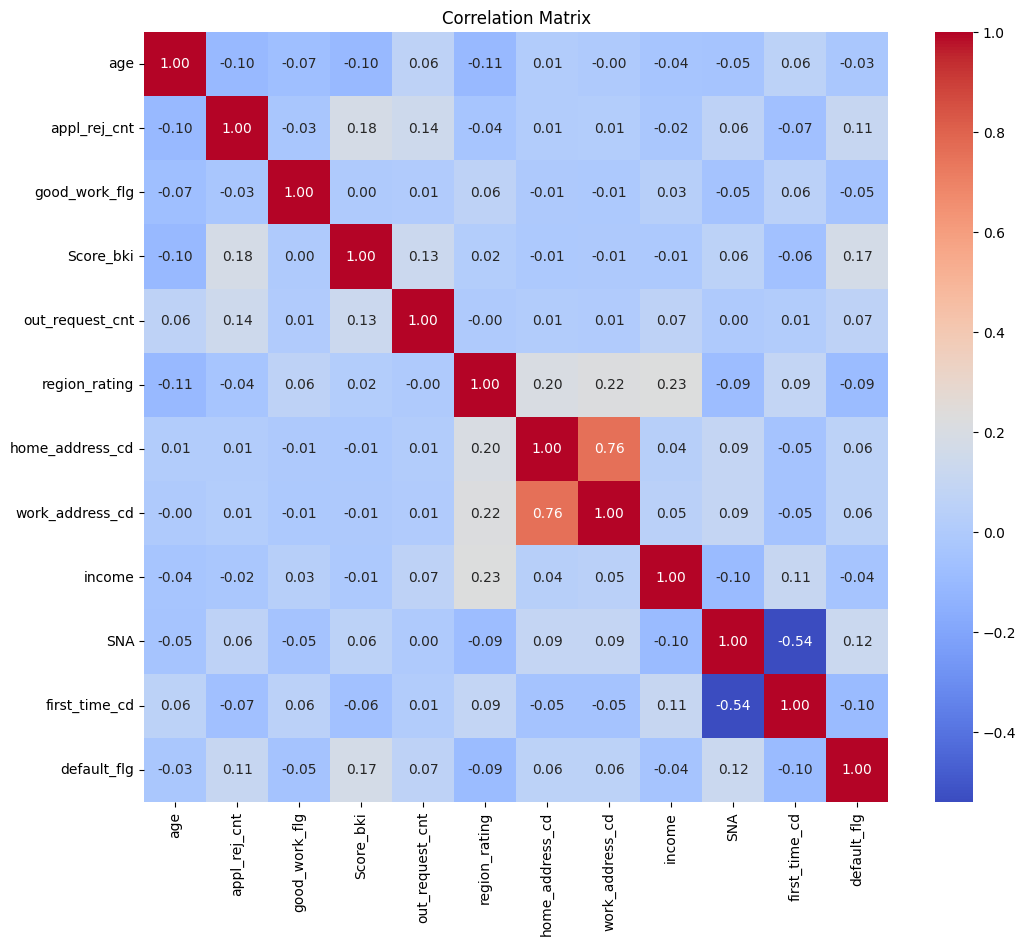

In [12]:
# -- КОРРЕЛЯЦИОННЫЙ АНАЛИЗ --

# Вычисление корреляционной матрицы только для числовых признаков
corr = df.select_dtypes(include=np.number).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

In [13]:
# -- РАЗДЕЛЕНИЕ НА ПРИЗНАКИ И ЦЕЛЕВУЮ ПЕРЕМЕННУЮ --

# Матрица признаков
X = df.drop(columns=['default_flg'], axis=1)

# Целевая переменная
y = df['default_flg']

In [14]:
# -- ОПРЕДЕЛЕНИЕ ТИПОВ ПРИЗНАКОВ --

# Числовые признаки
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
numeric_features

Index(['age', 'appl_rej_cnt', 'good_work_flg', 'Score_bki', 'out_request_cnt',
       'region_rating', 'home_address_cd', 'work_address_cd', 'income', 'SNA',
       'first_time_cd'],
      dtype='object')

In [15]:
# Категориальные признаки
categorical_features = X.select_dtypes(include=['object', 'category']).columns
categorical_features

Index(['education_cd', 'car_own_flg', 'car_type_flg', 'Air_flg'], dtype='object')

In [16]:
# Количество уникальных значений в категориальных признаках
X[categorical_features].nunique()

education_cd    5
car_own_flg     2
car_type_flg    2
Air_flg         2
dtype: int64

In [17]:
# -- ПРЕДОБРАБОТКА ПРИЗНАКОВ --

# Предобработка: числовые + категориальные признаки
preprocessor = ColumnTransformer([
    # Числовые признаки: медиана + стандартизация
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_features),

    # Категориальные признаки: мода + One-Hot Encoding
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_features)
])

In [18]:
# -- РАЗБИЕНИЕ НА ОБУЧАЮЩУЮ И ТЕСТОВУЮ ВЫБОРКИ --

# Разделение данных с сохранением пропорций классов
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Обучение предобработчика на train
preprocessed_X_train = preprocessor.fit_transform(X_train)

# Применение предобработки к test
preprocessed_X_test = preprocessor.transform(X_test)

# Получение имён сгенерированных признаков
features_names = preprocessor.get_feature_names_out()

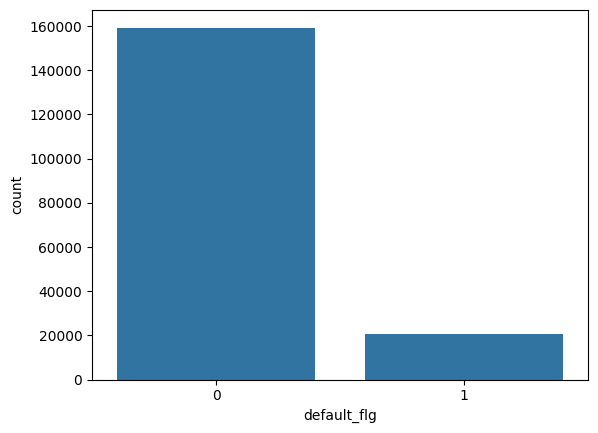

In [19]:
# -- АНАЛИЗ РАСПРЕДЕЛЕНИЯ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ --

# Визуализация распределения целевой переменной
sns.countplot(x=y)
plt.show()

In [20]:
# -- БАЛАНСИРОВКА КЛАССОВ (SMOTE) --

# Инициализация SMOTE
smote = over_sampling.SMOTE(random_state=42)

# Oversampling обучающей выборки
X_res, y_res = smote.fit_resample(preprocessed_X_train, y_train)

<Axes: >

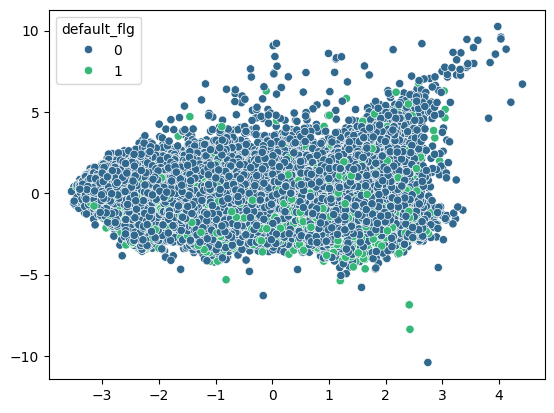

In [21]:
# -- ВИЗУАЛИЗАЦИЯ ДАННЫХ С ПОМОЩЬЮ PCA --

# PCA до SMOTE
pca = PCA(n_components=2)
X_pca = pca.fit_transform(preprocessed_X_train)

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train, palette='viridis')

<Axes: >

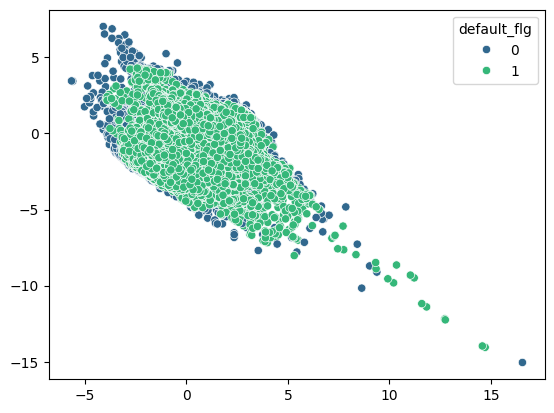

In [22]:
# PCA после SMOTE
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_res)

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_res, palette='viridis')

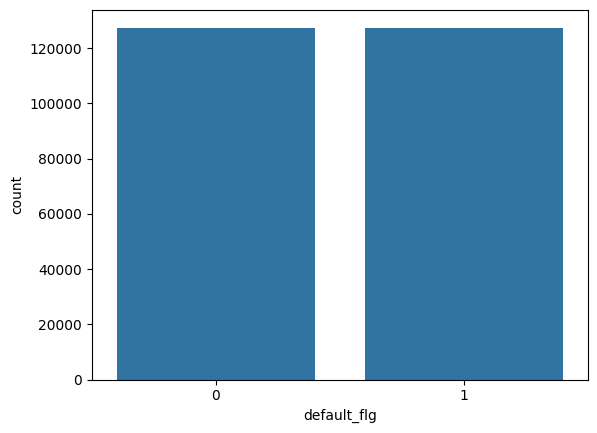

In [23]:
# Проверка баланса классов после SMOTE
sns.countplot(x=y_res)
plt.show()

In [24]:
# -- ОБУЧЕНИЕ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ С ПОДБОРОМ ПАРАМЕТРОВ --

# Базовая модель логистической регрессии
lr_model = LogisticRegression()

# Пространство гиперпараметров
lr_params = {
    'C': np.logspace(-4, 2, 20)
}

# Поиск оптимальных параметров
lr_search = RandomizedSearchCV(
    lr_model,          # базовая модель
    lr_params,         # пространство гиперпараметров
    n_iter=10,         # количество случайных комбинаций
    scoring='f1',      # целевая метрика (F1-score)
    random_state=42,   # фиксируем генератор случайных чисел
    cv=5,              # 5-кратная кросс-валидация
    n_jobs=-1          # использование всех доступных ядер CPU
)

# Обучение модели
lr_search.fit(X_res, y_res)

,estimator,LogisticRegression()
,param_distributions,{'C': array([1.0000...00000000e+02])}
,n_iter,10
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [25]:
# Функция оценки модели
def evaluate_model(model):
    y_pred = model.predict(preprocessed_X_test)
    print(classification_report(y_test, y_pred))

In [26]:
# Оценка лучшей модели
evaluate_model(lr_search.best_estimator_)

              precision    recall  f1-score   support

           0       0.94      0.66      0.77     31868
           1       0.20      0.67      0.31      4151

    accuracy                           0.66     36019
   macro avg       0.57      0.66      0.54     36019
weighted avg       0.85      0.66      0.72     36019



In [27]:
# Лучшие параметры
lr_search.best_params_

{'C': np.float64(0.03359818286283781)}

In [28]:
# -- ОБУЧЕНИЕ МОДЕЛИ XGBOOST --

# Инициализация классификатора XGBoost с параметрами по умолчанию
xgb_model = XGBClassifier()

# Пространство поиска гиперпараметров для RandomizedSearchCV
# Подбираются параметры сложности модели, регуляризации и скорости обучения
xgb_params = {
    'max_depth': [7, 9, 10],                 # максимальная глубина деревьев
    'gamma': [0.1, 0.15, 0.3],                # минимальное снижение функции потерь для разбиения
    'alpha': [0.1, 0.15, 0.3],                # L1-регуляризация (разреживание)
    'reg_lambda': [1.5, 2, 2.5],              # L2-регуляризация
    'learning_rate': [0.02, 0.05, 0.1],       # шаг обучения (shrinkage)
    'n_estimators': [200, 300, 400]           # количество деревьев
}

In [29]:
# Настройка случайного поиска гиперпараметров
xgb_search = RandomizedSearchCV(
    xgb_model,                                # базовая модель
    xgb_params,                               # пространство параметров
    n_iter=10,                                # количество случайных конфигураций
    scoring='f1',                             # оптимизация по F1-мере
    cv=4,                                     # кросс-валидация
    n_jobs=-1,                                # использование всех ядер CPU
    random_state=42                           # воспроизводимость результатов
)

# Обучение моделей XGBoost на сбалансированных данных (SMOTE)
xgb_search.fit(X_res, y_res)

,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'alpha': [0.1, 0.15, ...], 'gamma': [0.1, 0.15, ...], 'learning_rate': [0.02, 0.05, ...], 'max_depth': [7, 9, ...], ...}"
,n_iter,10
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,4
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [30]:
# Оценка качества лучшей найденной модели на тестовой выборке
evaluate_model(xgb_search.best_estimator_)

              precision    recall  f1-score   support

           0       0.89      0.98      0.93     31868
           1       0.32      0.06      0.11      4151

    accuracy                           0.88     36019
   macro avg       0.61      0.52      0.52     36019
weighted avg       0.82      0.88      0.84     36019



In [31]:
# -- ОБУЧЕНИЕ МОДЕЛИ CATBOOST --

# Инициализация CatBoost-классификатора
# Параметр silent=True отключает логирование в stdout
cat_model = CatBoostClassifier(silent=True)

# Пространство поиска гиперпараметров CatBoost
# Включает параметры сложности модели, регуляризации и стохастичности
cat_params = {
    "iterations": [300, 500, 800, 1200, 1500],     # число деревьев
    "learning_rate": [0.01, 0.02, 0.03, 0.05],     # скорость обучения
    "depth": [4, 5, 6, 7, 8, 10],                  # глубина деревьев
    "l2_leaf_reg": [1, 3, 5, 7, 9, 15, 20],        # L2-регуляризация листьев
    "bagging_temperature": [0, 1, 5, 10],          # степень стохастичности бутстрэппинга
    "random_strength": [0.5, 1, 2, 3, 5],          # уровень случайности при выборе разбиений
    "border_count": [32, 64, 128, 254],             # количество бинов для числовых признаков
}

In [32]:
# Настройка RandomizedSearchCV для CatBoost
cat_search = RandomizedSearchCV(
    estimator=cat_model,                           # базовая модель
    param_distributions=cat_params,                # пространство параметров
    n_iter=5,                                      # число случайных конфигураций
    scoring='f1',                                  # метрика оптимизации
    cv=4,                                          # кросс-валидация
    random_state=42,                               # воспроизводимость
    n_jobs=-1,                                     # параллельное выполнение
)

# Обучение CatBoost на сбалансированных данных
cat_search.fit(X_res, y_res)

,estimator,<catboost.cor...t 0x1312a05f0>
,param_distributions,"{'bagging_temperature': [0, 1, ...], 'border_count': [32, 64, ...], 'depth': [4, 5, ...], 'iterations': [300, 500, ...], ...}"
,n_iter,5
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,4
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [33]:
# Оценка лучшей модели CatBoost на тестовой выборке
evaluate_model(cat_search.best_estimator_)

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     31868
           1       0.43      0.03      0.06      4151

    accuracy                           0.88     36019
   macro avg       0.66      0.51      0.50     36019
weighted avg       0.83      0.88      0.84     36019



In [34]:
# -- ОБУЧЕНИЕ МОДЕЛИ RANDOM FOREST --

# Инициализация случайного леса
rf_model = RandomForestClassifier(random_state=42)

# Пространство поиска гиперпараметров Random Forest
# Учитывает контроль сложности модели и работу с дисбалансом классов
rf_params = {
    "n_estimators": [100, 200, 300, 500, 800],     # количество деревьев
    "max_depth": [None, 5, 8, 10, 12, 15, 20],     # максимальная глубина деревьев
    "min_samples_split": [2, 5, 10, 20, 50],       # минимальное число объектов для разбиения
    "min_samples_leaf": [1, 2, 5, 10, 20],         # минимальное число объектов в листе
    "max_features": ["sqrt", "log2", None],        # число признаков при разбиении
    "bootstrap": [True, False],                    # использование бутстрэппинга
    "class_weight": ["balanced", "balanced_subsample"]  # компенсация дисбаланса классов
}

In [35]:
# Настройка случайного поиска гиперпараметров
rf_search = RandomizedSearchCV(
    estimator=rf_model,                            # базовая модель
    param_distributions=rf_params,                 # пространство параметров
    n_iter=5,                                      # число итераций поиска
    scoring="f1",                                  # целевая метрика
    cv=4,                                          # кросс-валидация
    random_state=42,                               # воспроизводимость
    n_jobs=-1,                                     # параллельные вычисления
)

# Обучение Random Forest на сбалансированных данных
rf_search.fit(X_res, y_res)

# Просмотр лучших гиперпараметров
rf_search.best_params_

/Users/masha/src/creditscoring-personal/Submodules/credit_scoring/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'n_estimators': 100,
 'min_samples_split': 20,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': None,
 'class_weight': 'balanced',
 'bootstrap': False}

In [36]:
# Оценка качества лучшей модели
evaluate_model(rf_search.best_estimator_)

              precision    recall  f1-score   support

           0       0.89      0.96      0.92     31868
           1       0.28      0.13      0.18      4151

    accuracy                           0.86     36019
   macro avg       0.59      0.54      0.55     36019
weighted avg       0.82      0.86      0.84     36019



In [37]:
# -- СОХРАНЕНИЕ PIPELINE --

# Инициализация базовой логистической регрессии
model = LogisticRegression(max_iter=1000)

# Формирование pipeline: предобработка + модель
pipeline = Pipeline([
    ("preprocessor", preprocessor),                # этап предобработки признаков
    ("model", model),                              # классификатор
])

# Обучение pipeline на исходных обучающих данных
pipeline.fit(X_train, y_train)

# Сохранение обученного pipeline на диск
joblib.dump(pipeline, "pipeline.pkl")

['pipeline.pkl']

In [38]:
# -- ФИНАЛЬНЫЙ ПРОДАКШН PIPELINE С SMOTE --

# Явное задание числовых признаков
numeric_features = [
    "age", 
    "appl_rej_cnt", 
    "Score_bki", 
    "out_request_cnt",
    "region_rating", 
    "income", 
    "SNA", 
    "first_time_cd",
]

# Явное задание категориальных признаков
categorical_features = [
    "education_cd", 
    "car_own_flg", 
    "car_type_flg",
    "good_work_flg", 
    "home_address_cd", 
    "work_address_cd", 
    "Air_flg",
]

# Пайплайн предобработки числовых признаков
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()), 
])

# Пайплайн предобработки категориальных признаков
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")), 
    ("encoder", OneHotEncoder(handle_unknown="ignore")), 
])

# Объединение пайплайнов предобработки
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features), 
    ]
)

# Инициализация логистической регрессии с оптимальными параметрами
log_reg = LogisticRegression(
    C=0.03359818286283781,          # коэффициент регуляризации
    tol=0.0001,                     # критерий сходимости
    max_iter=100,                   # максимальное число итераций
    solver="lbfgs"                  # оптимизатор
)

# Финальный pipeline: предобработка + SMOTE + модель
pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor), # предобработка признаков
    ("smote", SMOTE(random_state=42)),  # балансировка классов
    ("model", log_reg)               # классификатор
])

# Формирование матрицы признаков и целевой переменной
X = df.drop(columns=["default_flg"])
y = df["default_flg"]

# Разбиение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Обучение финального pipeline
pipeline.fit(X_train, y_train)

# Получение предсказаний на тестовой выборке
y_pred = pipeline.predict(X_test)

# Вывод отчёта по качеству классификации
print("\n=== Classification Report ===\n")
print(classification_report(y_test, y_pred))

# Сохранение финального pipeline
joblib.dump(pipeline, "credit_scoring_pipeline.pkl")
print("\nPipeline saved as credit_scoring_pipeline.pkl")



=== Classification Report ===

              precision    recall  f1-score   support

           0       0.94      0.66      0.77     31868
           1       0.20      0.66      0.31      4151

    accuracy                           0.66     36019
   macro avg       0.57      0.66      0.54     36019
weighted avg       0.85      0.66      0.72     36019


Pipeline saved as credit_scoring_pipeline.pkl


In [ ]:
# Сохранение финального pipeline
# joblib.dump(pipeline, MODEL_OUTPUT_PATH)

['../credit_scoring_pipeline.pkl']

In [40]:
# Вывод списка используемых признаков
print("NUMERIC:", numeric_features)
print("CATEGORICAL:", categorical_features)

NUMERIC: ['age', 'appl_rej_cnt', 'Score_bki', 'out_request_cnt', 'region_rating', 'income', 'SNA', 'first_time_cd']
CATEGORICAL: ['education_cd', 'car_own_flg', 'car_type_flg', 'good_work_flg', 'home_address_cd', 'work_address_cd', 'Air_flg']
